# Temperature Profile Modifications

Started 2 November 2019. This is to test toy modifications to the Shakura-Sunyaev $T(r)$ with the modification added by KHH88.

### Imports

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct29 import *
from fu_ori_classes_oct29 import *
import matplotlib.gridspec as gridspec

import emcee
import corner
import time
%matplotlib inline 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Testing modifications to temperature profile

In [3]:
M_STAR = 0.62*M_SUN
R_STAR= 1.63*R_SUN
R_OUTER = 100 * R_STAR
M_DOT = (10**0.66) * 1e-6 * M_SUN / 3.154e7

A_V = 2.35
INC = 45
DIST = 795*3.08567758128e18

In [4]:
def tempKepDisk(r, r_inner, m_dot, m_star):
    term1 = 3*G*m_star*m_dot / (8 * np.pi * SIG_SB * (r**3))
    term2 = (1 - (r_inner/r)**(1/2))
    return (term1 * term2)**(1/4)


# def tempFUOriDisk(r, r_inner, m_dot, m_star):
#     res = np.zeros(len(r))
#     for i in range(len(r)):
#         if r[i] <= RAD_MAX_DISK*r_inner:
#             res[i] = tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star)
#         else:
#             res[i] = tempKepDisk(r[i], r_inner, m_dot, m_star)
#     return res

def tempFUOriDisk(r, r_inner, m_dot, m_star, pl_index):
    res = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] <= RAD_MAX_DISK*r_inner:
            t_max =  tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star)
            res[i] = t_max*((r[i]/(RAD_MAX_DISK*r_inner))**pl_index)
        else:
            res[i] = tempKepDisk(r[i], r_inner, m_dot, m_star)
    return res

In [5]:
def tempFUOriDiskModified(r, r_inner, m_dot, m_star, pl_index):
    res = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] <= RAD_MAX_DISK*r_inner:
            t_max =  tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star)
            res[i] = t_max*((r[i]/(RAD_MAX_DISK*r_inner))**pl_index)
        else:
            res[i] = tempKepDisk(r[i], r_inner, m_dot, m_star)
    return res

In [6]:
def tempFUOriDiskMod(r, r_inner, m_dot, m_star, pl_index):
    if r <= RAD_MAX_DISK*r_inner:
        t_max = tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star)
        res = t_max*((r/(RAD_MAX_DISK*r_inner))**pl_index)
    else:
        res = tempKepDisk(r, r_inner, m_dot, m_star)
    return res
    
def tempFUOriDiskMin(r, r_inner, m_dot, m_star, val, pl_index):
    return tempFUOriDiskMod(r, r_inner, m_dot, m_star, pl_index) - val

In [7]:
TT, RRA, RRB = generateMasterListInner(R_STAR, 1.361*R_STAR, M_DOT, M_STAR, 10e3, 2e3, 200, 0)

NameError: name 'generateMasterListInner' is not defined

In [ ]:
TT, RRA/R_STAR, RRB/R_STAR

In [ ]:
a_list = np.array([1])
b_list = np.array([4,5,56])
np.concatenate((a_list, b_list))

In [ ]:
TT, RRA, RRB = generateMasterList(R_STAR, 8*R_STAR, M_DOT, M_STAR, 10e3, 2e3, 2e2, R_STAR,0)

In [ ]:
TT, RRA/R_STAR, RRB/R_STAR

In [ ]:
def find_nearest(array, value, side):
    array = np.asarray(array)
    min_vals = array-value
    max_vals = -min_vals
    if side == 'above':
        for i in range(len(min_vals)):
            if min_vals[i] < 0: min_vals[i] = np.inf
        idx = min_vals.argmin()
    if side == 'below':
        for i in range(len(min_vals)):
            if max_vals[i] < 0: max_vals[i] = np.inf
        idx = max_vals.argmin()
    return array[idx]

def getAvgOfPairs(arr):
    out_arr = np.zeros(len(arr)-1)
    for i in range(len(arr)-1):
        out_arr[i] = np.mean([arr[i], arr[i+1]])
    return out_arr

def makeOuterAnnuli(r_inner, r_outer, m_dot, m_star, r_start, r_binning, pl_index):
    r_list = np.arange(r_start, r_outer+r_binning, r_binning)
    r_a = r_list[:-1]
    r_b = r_list[1:]
    r_avg = np.mean((r_a,r_b), axis=0)
    temps = tempFUOriDisk(r_avg, r_inner, m_dot, m_star, pl_index)
    return temps, r_a, r_b

def generateMasterListInner(r_inner, r_tmax, m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, pl_index):
    # Max and min temperatures of defined disk
    temp_inside = tempFUOriDiskMod(r_inner, r_inner, m_dot, m_star, pl_index)
    temp_outside = tempFUOriDiskMod(r_tmax, r_inner, m_dot, m_star, pl_index)
    
    # These designations account for the inner temp being 
    # similar to the outer temp
    epsilon = temp_binning
    temp_in_greater = 0
    if temp_inside > temp_outside + epsilon:
        temp_in_greater = 1
    elif temp_outside > temp_inside + epsilon:
        temp_in_greater = -1
        
    # Looking at all possible temperatures of given library
    temp_prelim = np.arange(temp_min_poss - 0.5*temp_binning, temp_max_poss + 1.5*temp_binning, temp_binning)
    
    if temp_in_greater == 1:
        max_temp = tempFUOriDiskMod(r_inner, r_inner, m_dot, m_star, pl_index)
        min_temp = tempFUOriDiskMod(r_tmax, r_inner, m_dot, m_star, pl_index)
    elif temp_in_greater == -1:
        min_temp = tempFUOriDiskMod(r_inner, r_inner, m_dot, m_star, pl_index)
        max_temp = tempFUOriDiskMod(r_tmax, r_inner, m_dot, m_star, pl_index)
    else:
        low_lim = find_nearest(temp_prelim, temp_inside, 'below')
        high_lim = find_nearest(temp_prelim, temp_inside, 'above')
        return np.array([np.mean((low_lim, high_lim))]), np.array([r_inner]), np.array([r_tmax])
                                                                             
    # Finding ranges within the full temperature library
    min_nearest = find_nearest(temp_prelim, min_temp, 'above')
    max_nearest = find_nearest(temp_prelim, max_temp, 'below')
    
    # Making new list for annuli
    temp_spaced = np.arange(min_nearest, max_nearest + temp_binning, temp_binning)

    r_a = np.zeros(len(temp_spaced))
    for i in range(len(temp_spaced)):
        sol = optimize.root_scalar(tempFUOriDiskMin,args=(r_inner, m_dot, m_star, temp_spaced[i], pl_index),\
                                   bracket=[r_inner, r_tmax], method='brentq')
        r_a[i] = sol.root
        
    if temp_in_greater == 1:
        r_a = np.concatenate((r_a, [r_inner]))[::-1]
        r_b = np.concatenate((r_a[1:], [r_tmax]))
                            
    elif temp_in_greater == -1:
        r_a = np.concatenate(([r_inner], r_a))
        r_b = np.concatenate((r_a[1:], [r_tmax]))
    
    # Average temperatures of annuli
    temp_radiating_prelim = getAvgOfPairs(temp_spaced)
    temp_radiating = np.concatenate(([np.min(temp_radiating_prelim) - temp_binning],\
                                     temp_radiating_prelim,\
                                     [np.max(temp_radiating_prelim) + temp_binning]))
    
    # Adding temperatures below final stellar atmosphere
    # EXCLUDING FINAL VALUES since they're accounted for in the outer annuli
    temp_radiating_curr = temp_radiating
    if temp_in_greater == 1:
        temp_radiating_curr = temp_radiating_curr[::-1]
    r_a_curr = r_a
    r_b_curr = r_b

    return temp_radiating_curr, r_a_curr, r_b_curr

def generateMasterListOuter(r_inner, r_outer, r_tmax, m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer, pl_index):
    # Max and min temperatures of defined disk
    max_temp = tempFUOriDiskMod(r_tmax, r_inner, m_dot, m_star, pl_index)
    min_temp = tempFUOriDiskMod(r_outer, r_inner, m_dot, m_star, pl_index)
    
    # Looking at all possible temperatures of given library
    temp_prelim = np.arange(temp_min_poss - 0.5*temp_binning, temp_max_poss + 1.5*temp_binning, temp_binning)
    min_nearest = find_nearest(temp_prelim, min_temp, 'above')
    max_nearest = find_nearest(temp_prelim, max_temp, 'below')
    
    # Making new list for annuli
    temp_spaced = np.arange(min_nearest, max_nearest + temp_binning, temp_binning)
    r_a = np.zeros(len(temp_spaced)+1)
    for i in range(len(temp_spaced)):
        sol = optimize.root_scalar(tempFUOriDiskMin,args=(r_inner, m_dot, m_star, temp_spaced[i], pl_index),\
                                   bracket=[r_tmax, r_outer], method='brentq')
        r_a[i] = sol.root
    r_a[-1] = r_tmax
    r_b = np.concatenate(([r_outer], r_a))[:-1]
    
    # Average temperatures of annuli
    temp_radiating_prelim = getAvgOfPairs(temp_spaced)
    temp_radiating = np.concatenate(([np.min(temp_radiating_prelim) - temp_binning],\
                                     temp_radiating_prelim,\
                                     [np.max(temp_radiating_prelim) + temp_binning]))
    
    # Adding temperatures below final stellar atmosphere
    # EXCLUDING FINAL VALUES since they're accounted for in the outer annuli
    temp_radiating_curr = temp_radiating[::-1][:-1]
    r_a_curr = r_a[::-1][:-1]
    r_b_curr = r_b[::-1][:-1]
    r_start = r_b_curr[-1]
    temp_radiating_outer, r_a_outer, r_b_outer = makeOuterAnnuli(r_inner, r_outer,\
                                        m_dot, m_star, r_start, r_binning_outer, pl_index)
    
    temp_radiating_final = np.concatenate((temp_radiating_curr, temp_radiating_outer))
    r_a_final = np.concatenate((r_a_curr, r_a_outer))
    r_b_final = np.concatenate((r_b_curr, r_b_outer))
    
    return temp_radiating_final, r_a_final, r_b_final

def generateMasterList(r_inner, r_outer, m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer, pl_index):
    # Replace this at some point?
    RAD_MAX_DIST = RAD_MAX_DISK*r_inner
    inner_lists = generateMasterListInner(r_inner, RAD_MAX_DIST,\
                                          m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, pl_index)
    outer_lists = generateMasterListOuter(r_inner, r_outer, RAD_MAX_DIST,\
                                          m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer, pl_index)
    
    final_lists = []
    for i in range(len(inner_lists)):
        final_lists.append(np.concatenate((inner_lists[i], outer_lists[i])))
    return final_lists 

In [35]:
x_vals = np.linspace(R_STAR, 8*R_SUN, 10000)
y_vals = tempKepDisk(x_vals, R_STAR, M_DOT, M_STAR)
y_vals_KHH = tempFUOriDisk(x_vals, R_STAR, M_DOT, M_STAR, 0)
y_vals_Mod = tempFUOriDiskModified(x_vals, R_STAR, M_DOT, M_STAR,-1)
y_vals_Mod2 = tempFUOriDiskModified(x_vals, R_STAR, M_DOT, M_STAR,1)

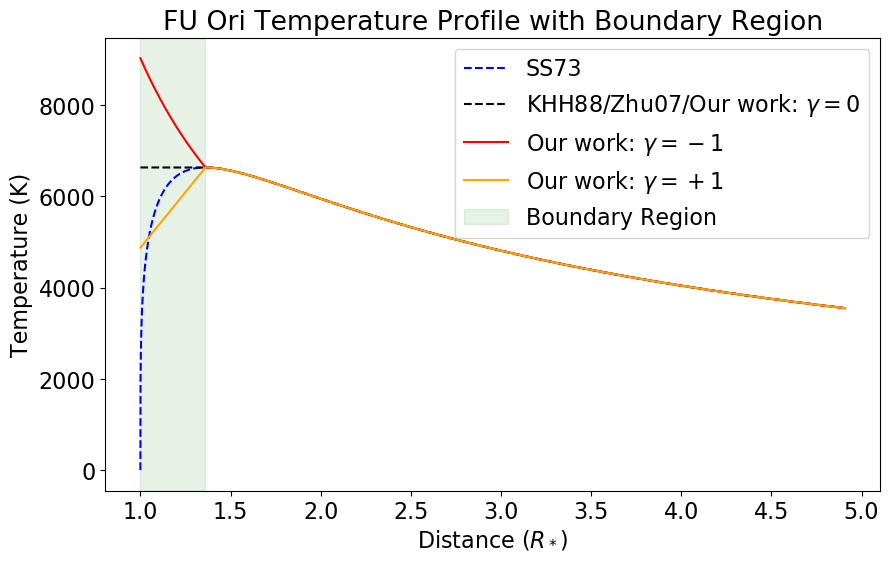

In [44]:
fig=plt.figure(figsize=(10, 6), dpi= 100)
plt.rcParams.update({'font.size': 16})
plt.title('FU Ori Temperature Profile with Boundary Region')
plt.ylabel('Temperature (K)')
plt.xlabel(r'Distance ($R_*$)')
plt.plot(x_vals/R_STAR, y_vals, 'b--', label='SS73')
plt.plot(x_vals/R_STAR, y_vals_KHH, 'k--', label=r'KHH88/Zhu07/Our work: $\gamma = 0$')
plt.plot(x_vals/R_STAR, y_vals_Mod, 'r-', label=r'Our work: $\gamma = -1$')
plt.plot(x_vals/R_STAR, y_vals_Mod2, 'orange', label=r'Our work: $\gamma = +1$')

# plt.ylim(0, 10000)
plt.axvspan(1, 1.361, color='g', alpha=0.1, label = 'Boundary Region')
# plt.xlim(0.9, 3)

plt.legend()
# plt.savefig("new_temp_profiles_linear.png", dpi=200, bbox_inches='tight')

plt.show()

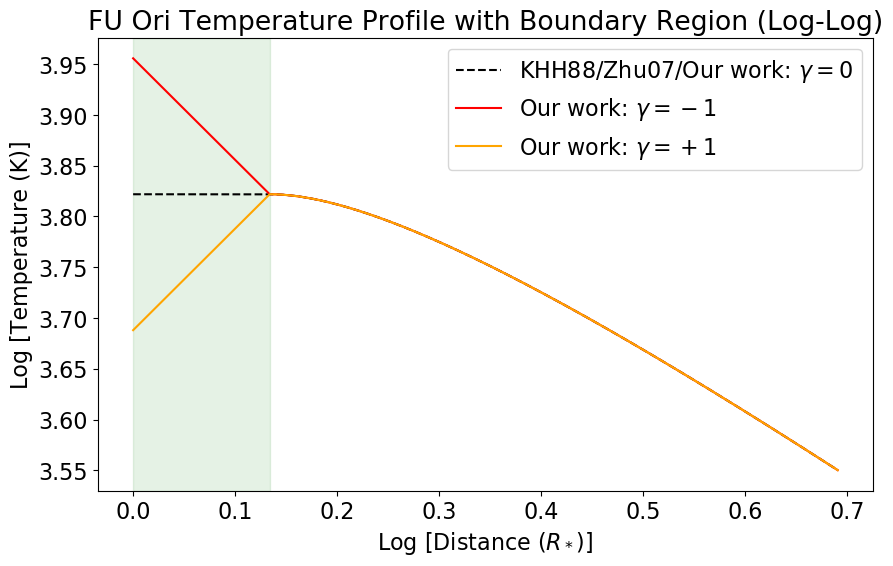

In [45]:
fig=plt.figure(figsize=(10, 6), dpi= 100)
plt.rcParams.update({'font.size': 16})
plt.title('FU Ori Temperature Profile with Boundary Region (Log-Log)')
plt.ylabel('Log [Temperature (K)]')
plt.xlabel(r'Log [Distance ($R_*$)]')
plt.plot(np.log10(x_vals/R_STAR), np.log10(y_vals_KHH), 'k--', label=r'KHH88/Zhu07/Our work: $\gamma = 0$')
plt.plot(np.log10(x_vals/R_STAR), np.log10(y_vals_Mod), 'r-', label=r'Our work: $\gamma = -1$')
plt.plot(np.log10(x_vals/R_STAR), np.log10(y_vals_Mod2), 'orange', label=r'Our work: $\gamma = +1$')

# plt.ylim(0, 10000)
plt.axvspan(0, np.log10(1.361), color='g', alpha=0.1)

plt.legend()
# plt.savefig("new_temp_profiles_log.png", dpi=200, bbox_inches='tight')

plt.show()